# Cryptographic hash functions

A cryptographic hash function satisfies the following properties (see [Rogaway and Shrimpton](https://eprint.iacr.org/2004/035)):

> **preimage-resistance / one-way function**: for essentially all pre-specified outputs, it is computationally infeasible to find any input which hashes to that output, i.e., to find any preimage $x'$ such that $h(x') = y$ when given any $y$ for which a corresponding input is not known

> **2nd-preimage / weak collision resistance**: it is computationally infeasible to find any second input which has the same output as any specified input, i.e., given $x$, to find a 2nd-preimage $x' \neq x$ such that $h(x) = h(x')$.

> **strong collision resistance**: it is computationally infeasible to find any two distinct inputs $x, x'$ which
hash to the same output, i.e., such that $h(x) = h(x')$.

Let's take a look at a practical example.

In [16]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes

# initialize the digest object with the required hash algorithm
digest = hashes.Hash(hashes.SHA256(), backend=default_backend())

# the message to be encoded should be a bytes object (byte array);
# if you specify a string without encoding, each character might be read as more than one byte
message = 'to hash'.encode('utf-8')

# the digest object is updated with message contents
digest.update(message)

# any further string updates are appended to the message to be hashed
digest.update('append to message'.encode('utf-8'))

# finalizing the digest object disables any further updates and returns the hash
# output as hexadecimal to be a little more legible
digest.finalize().hex()

'97e6c5c06e30d8e6de51d5b923fb6b1efab0061732eb23634e1f856694c075ca'

**Exercise**: try changing a single letter of the message, and verify that the digest changes completely.

**Exercise**: Verify that the message digest if the length you expect from a [SHA-256](https://en.wikipedia.org/wiki/SHA-2) hash. Try changing the hash algorithm to one with a different digest length, e.g. [MD5](https://en.wikipedia.org/wiki/MD5).

## Integrity, non-repudiation, and collision attacks

Hash functions are commonly used to guarantee **integrity** of a message, or a file.
1. The smallest change in input leads to a large change in output.
2. Hash digests are very small, usually much smaller than the message.
3. Digests are very quick to compute in software.

In order to rely on hash functions for this use in general, they need to be resistant against not only preimage but also collision attacks. If a collision can be found with a practical algorithm, it becomes possible to generate two files with different content but the same hash - see below for links to examples (advanced topic).

The so-called *birthday attack* works on any hash function and is therefore considered the point of reference for collision attacks. You can read up on the [birthday problem](https://en.wikipedia.org/wiki/Birthday_problem) for your information. For the purpose of this exercise, assume that the following is true.

> **Birthday problem**: Suppose a sequence of integers $I=\{i\}_{j=1}^n$ are drawn uniformly at random with replacement in the range $[1,d]$. Let the probability that any two of these integers are equal be
>
> $
\begin{align*}
    p(n,d) & = \mathbb{P}(i_j=i_k) \qquad \mbox{for any} \; i_j, i_k \in I \\
           & = 1 -  \binom{d}{n} \frac{ n! }{ d^n} \\
           & \approx 1-e^{-n(n-1)/(2d)}
\end{align*}    
$.
>
> The number of random integers required to obtain a given $p$ is
>
> $n(p,d) \approx \left[2d\ln\left(\frac{1}{1-p}\right)\right]^{1/2}$

This result applies to *ideal* hash functions to the extent that digests are indistinguishable from random numbers.

**Exercise**: suppose there are $n$ students in your classroom. Each person has a birthday that can be mapped to the range $[1,366]$. Calculate the probability that any two out of $n$ students have the same birthday. Calculate the number of students required for probablities in the range $[0.1, 0.9]$.

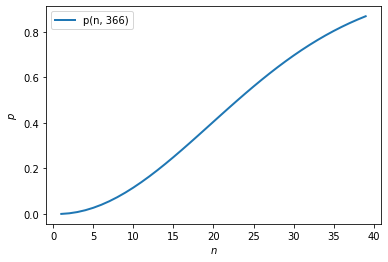

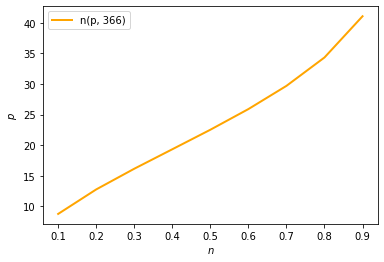

In [15]:
from numpy import arange, exp, log, sqrt
%matplotlib inline
import matplotlib.pyplot as pplt

d = 366
n = arange(1,40)
p = 1 - exp(-n*(n-1)/(2*d))

pplt.plot(n, p, linewidth=2, label='p(n, {0})'.format(d))
pplt.xlabel('$n$')
pplt.ylabel('$p$')
pplt.legend()
pplt.show()

p = arange(.1,1,.1)
n = sqrt(2*d*log(1/(1-p)))
pplt.plot(p, n, linewidth=2, label='n(p, {0})'.format(d), color='orange')
pplt.xlabel('$n$')
pplt.ylabel('$p$')
pplt.legend()
pplt.show()

**Exercise**: How many random digests would you need to compute to find a collision in MD5 with a probability of $1/2$?

# Passwords
Hash functions are routinely used to store passwords, for several reasons - one of them being that if a company's database is stolen, user passwords should not be instantly compromised. For this use case, preimage resistance is a crucial property.

**Example**: suppose a company's user database has been stolen and published, with each entry containing username, IP address, email address, and hashed password. Suppose one specific password $x$ hashes to the following string, under SHA-256:
> $H(x)=$'7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451'

It should be infeasible for you to guess what $x$ is, assuming:
1. SHA-256 is a cryptographic hash function, as per the definitions above; and
2. there is a high uncertainty in the possible choice of password $x$.

The second requirement is due to hash functions being deterministic: there is no uncertainty in the result of the computation $h=H(x)$.

## Dictionary attack

In some cases, it is possible to do better than a brute force attack because the space of all *plausible* input is much smaller than the space of all *possible* input. This is known as a *dictionary attack*.

Suppose I also told you that the string $x$ is composed of a single digit number. There would be 10 possible different values of $x$ - in other words, the size of the message space would be $\#\mathcal{M}=10$ - and even without knowing $x$ it would take very little time and effort to recover $x$ by brute force, like so:

In [18]:
for x in range(10):
    digest = hashes.Hash(hashes.SHA256(), backend=default_backend())
    digest.update(str(x).encode())
    h = digest.finalize().hex()
    print('''SHA-256('{0}') = {1}'''.format(x, h))

SHA-256('0') = 5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9
SHA-256('1') = 6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b
SHA-256('2') = d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35
SHA-256('3') = 4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce
SHA-256('4') = 4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328cb08b5531fcacdabf8a
SHA-256('5') = ef2d127de37b942baad06145e54b0c619a1f22327b2ebbcfbec78f5564afe39d
SHA-256('6') = e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683
SHA-256('7') = 7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451
SHA-256('8') = 2c624232cdd221771294dfbb310aca000a0df6ac8b66b696d90ef06fdefb64a3
SHA-256('9') = 19581e27de7ced00ff1ce50b2047e7a567c76b1cbaebabe5ef03f7c3017bb5b7


This can lead to what is known as a *brute force* attack: it is possible, in principle, to exhaustively enumerate $H(x)$ for every $x$, store these values in a table, and then given a hash value $h$ to search the table for some message $m$ whose digest will be $H(m)=x$. The constraints are:
1. Time and cost required to compute all possible hashes
2. Space and cost required to store all possible digests

**Example**: the space of all possible English letters (upper-and lower-case) is of size $\#L=2\cdot26$. Suppose it takes 1ms to compute a single SHA-256 hash. A message drawn uniformly at random from the space of 8-letter passwords forces a brute-force adversary to expend the following resources:

Total number of possibilities | Storage memory required (terabytes) | Time to compute (years)
--- | --- | ---
$n=(2\cdot26)^8$ | $n\cdot(256 + 8\cdot 8)/(8\cdot10^{12}) $  | $n/(1000\cdot60\cdot60\cdot24\cdot356)$

In [3]:
n = (2*26)**8
memory = n*(256+64)/(8*10**12)
time = n/(1000*60*60*24*365)
print('possibilities: {0}'.format(n))
print('memory: {0} Tb'.format(memory))
print('time to compute: {0} years'.format(time))

possibilities: 53459728531456
memory: 2138.38914125824 Tb
time to compute: 1695.1968712409944 years


**Exercise**: Can you see where the storage requirement computation comes from?

The possibilities also need to be stored so that we can look up the password from the hash. For each possibility we need to store both the 64-bit password and the 256-bit hash.

**Exercise**: compute the SHA-256 hash of the top 10 [most common passwords](https://en.wikipedia.org/wiki/List_of_the_most_common_passwords) of 2019. Is '8bb0cf6eb9b17d0f7d22b456f121257dc1254e1f01665370476383ea776df414' one of them?

**Exercise**: the number of all existing English words, of any length, is somewhere near $6\cdot 10^5$ - see e.g. [wolfram|alpha](https://www.wolframalpha.com/input/?i=number+of+words+in+english). Assume that the most frequent word is as likely to be used as a password as the most infrequent one, and compute the following values:

Total number of possibilities | Total storage memory required (megabytes) | Time to compute (seconds)
--- | --- | ---
$6\cdot10^5$ | ? | ?

It is possible in theory to pre-compute every single $h=H(x)$ for all $x$, if the message space or the digest space is small enough, to build a lookup table: each entry in the table associates the key-value pair $h,x$ so anyone with the table can look up a value of $x$, given a key $h$. It can be an expensive process, but only needs to be done once.

**Exercise**: compute the MD5 and/or SHA1 hash of a password and see if it has already been pre-computed and uploaded to an online database, for instance [isc.sans.edu/tools/reversehash](https://isc.sans.edu/tools/reversehash.html).

## Rainbow tables

Computing brute force possibilities at runtime and looking up all pre-computed values are two extreme cases: in the former there is no storage but a random computational effort has to be expended every time; in the latter, a fixed computational effort is expended only once, and a maximal storage effort must be maintained. A *[rainbow table](https://en.wikipedia.org/wiki/Rainbow_table)* trades off storage of pre-computed values against runtime computational effort.

Suppose we define some function $G$ mapping hash values back into passwords, and we construct a table by computing the chain of values

$
\begin{align*}
    p & \in P_1 \\
    h & = H(p) \in H_1 \\
    p' & = G(h) \in P_2 \\
    h' & = H(p')\in H_2
\end{align*}
$

Suppose we make the rather unrealistic assumption that we can find a $G$ and the sets $P_1,P_2$ and $H_1, H_2$ are disjoint. *If* we could find such a $G$, and if we had the capacity to compute all of $P_2$ and to store a table mapping $P_1$ into $H_2$, then we could examine any new hash value $\tilde{h}$ and conclude that one of the following is true:

* $\tilde{h}\in H_2$, therefore we can compute the corresponding $p'$
* $G(\tilde{h}) \in P_1$, therefore we have just computed the corresponding $p$
* $\tilde{h}$ is not the hash of a password in the space we initially considered.

The storage requirement for this algorithm, $P_1,H_2,G$ is half that of the full pre-computed table $H,P$, and it only requires a single hash computation at runtime for every look-up.

## Salted hash

A common mitigation strategy against pre-computation is to add a random *salt* $s$ to every hash: password hashes are computed as $h=H(x,s)$, and stored in a database as pairs $(h,s)$.

**Exercise**: Suppose passwords are chosen as a single random word in the English language and computed with MD5. What are the number of possibilities, storage requirements, and time to compute every possible $h$ in the two following scenarios:
1. no salt
2. a random 32-bit salt

## Linux user passwords

The linux function used to hash passwords is `crypt(3)`. You can check the man page on your distribution, or see [here](http://manpages.ubuntu.com/manpages/disco/en/man3/crypt.3.html). As you can see, salting algorithms are specified by an `$id` variable, and salts are encoded as strings of *up to* 16 characters, taken from a set of 64 possible values each, namely `[a-zA-Z0-9./]`. To quote:

> ID  | Method
> --- | ---
> 1   | MD5
> 2a  | Blowfish (not in mainline glibc; added in some Linux distributions)
> 5   | SHA-256 (since glibc 2.7)
> 6   | SHA-512 (since glibc 2.7)

However, note well: if no `id` is specified, the function defaults to a DES-based algorithm with a two-character salt. Note that [DES](https://en.wikipedia.org/wiki/Data_Encryption_Standard) is a block cipher with a 64-bit block size. If you have not seen block ciphers before, simply treat this as if it were a hash function with a 4-bit digest for the purposes of this exercise.

Lastly, note that [OWASP recommend](https://github.com/OWASP/CheatSheetSeries/blob/master/cheatsheets/Password_Storage_Cheat_Sheet.md) that every password be salted with a 32- or 64-bit random number.

**Exercise**: Compute the number of possibilities, memory, and time requirements in each of the following scenarios:
0. DES with a 2-character salt
1. MD5 with a 128-bit salt
2. SHA-256 with a 256-bit salt

**Exercise**: if you have access to a linux machine, one way to check how your account passwords are being created is by
> `xed /etc/shadow`

Note that you *should* need administrator privileges to access this file, for good reason. You can check the permissions on this file by
> `ls -l /etc/shadow`

and you should probably see something beginning with
> `-rw-r----- 1 root shadow`

meaning the file belongs to the `root` user with read and write access, and that anyone in the `shadow` group has read access.

Once you do manage to open it, please *don't make any changes to this file* while looking!

## Standards
A list of approved hash functions is maintained by [NIST](https://csrc.nist.gov/Projects/Hash-Functions).

We have discussed the principle and motivation for password hashing and salting. As you should have seen in the linux password case, it is not enough to simply generate a hash; we also need to specify which algorithm and parameters were used so that a verification function can be correctly executed. Each protocol will likely have its own requirements. For instance, the WPA wifi protocol uses the [PBKDF2](https://en.wikipedia.org/wiki/PBKDF2) (Password-Based Key Derivation Function; see NIST [SP 800-132](https://csrc.nist.gov/publications/detail/sp/800-132/final)) standard.

Rather than implementing your own version of each password hash creation and verification algorithm, you will most likely want to make use of existing libraries such as [passlib](https://passlib.readthedocs.io/en/stable/).

## Attack budget

Note that an exhaustive search can always be parallelized across several machines, if you have enough money to spend on hardware and electricity. For instance, a [GeForce GTX 1080 Ti](https://www.nvidia.com/en-us/geforce/products/10series/geforce-gtx-1080-ti/) has a [reported](https://www.techspot.com/article/1438-ethereum-mining-gpu-benchmark/) hashrate of 31.3 MH/s. Since these are measured as double SHA-256 for mining purposes, let's count it as $62.6 \cdot  10^6$ SHA-256 operations per second.

**Exercise**: Suppose an adversary wants to crack a single password, knowing the 256-bit salt and the SHA-256 hash. Calculate how much time and money it costs to recover that one password using a single GTX card, in the worst case - i.e. ignore the probability that the computation will find a match long before every possible password has been tried. Make the following assumptions:
* the cost of one card is about 600€
* the card consumes a constant 180 W of power
* the average electricity retail price of electricity is 0.10€ per kW$\cdot$h
* ignore any other equipment and cooling costs
* the password to be recovered is a truly random string of 256 bits.

**Exercise**: calculate the cost to parallelize the operation in the previous exercise such that the time taken in the worst case is less than 1 week.

**Exercise**: repeat the calculation by changing the last assumption:
* the password to be recovered is one of the $6\cdot 10^5$ words in the English language.

**Exercise**: How much would it cost to pre-compute all posible SHA-256 digests of every word in the English language with the every possible 32-bit salt appended to each one?

Now, go to [haveibeenpwned.com](https://haveibeenpwned.com) and check when and how many times your hashed and salted passwords have been stolen from databases. Make a note of how long ago that happened, and see if you can find out what the hashing algorithm and the salt length were.

## Advanced collision attacks

You can find online a demo of a practical [MD5 collision attack](https://www.mscs.dal.ca/~selinger/md5collision/) to generate two different executables - one with malware, one without - and of a practical [SHA1 collision attack](http://shattered.io/) to generate two different pdfs with the same hash, which could be applied to create two versions of a signed contract.

The examples above are specific to the hash function algorithm they were designed for.

# Theme
You can run the following cell to change the appearance of this notebook to suit your taste. Check for available themes on [github.com/dunovank/jupyter-themes](https://github.com/dunovank/jupyter-themes).

In [7]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')